# Keras for Text Classification

In [ ]:
# Ensure that we have the right version of Tensorflow installed.
!pip freeze | grep tf-nightly-2.0-preview || pip install tf-nightly-2.0-preview

In [102]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.0.0-dev20190917


In [6]:
%matplotlib inline

In [100]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

In [56]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,show hn tubemaps tube routes from terminal ...,github
1,data-crunching is coming to help your boss man...,nytimes
2,joy in factor,github
3,silicon valley you and some of your vc s have...,techcrunch
4,music lessons on webcams grow in popularity,nytimes


## Integerize the texts

In [57]:
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(titles_df.title)
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)

integerized_titles[:3]

[[11, 12, 23705, 6117, 3330, 17, 316, 7, 45, 18],
 [32, 6447, 13, 373, 3, 161, 15, 1714, 670, 15, 1304],
 [3960, 5, 1792]]

In [58]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [59]:
vocabulary = [tokenizer.index_word[i] for i in range(1, VOCAB_SIZE + 1)]
vocabulary[:5]

['the', 'a', 'to', 'for', 'in']

In [60]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [61]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

In [62]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [63]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[   11,    12, 23705,  6117,  3330,    17,   316,     7,    45,
           18,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   32,  6447,    13,   373,     3,   161,    15,  1714,   670,
           15,  1304,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 3960,     5,  1792,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [64]:
titles_df.source[:4]

0        github
1       nytimes
2        github
3    techcrunch
Name: source, dtype: object

In [65]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [66]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [67]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## Preparing the train/test splits

In [101]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [69]:
sources_train.value_counts()

github        29313
techcrunch    24710
nytimes       22939
Name: source, dtype: int64

In [70]:
sources_valid.value_counts()

github        7212
techcrunch    6181
nytimes       5848
Name: source, dtype: int64

In [71]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [72]:
X_train[:3]

array([[   11,    12, 23705,  6117,  3330,    17,   316,     7,    45,
           18,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   32,  6447,    13,   373,     3,   161,    15,  1714,   670,
           15,  1304,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 3960,     5,  1792,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [73]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Building a DNN model

In [86]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]),
        Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 1s 18us/sample - loss: 1.0474 - accuracy: 0.4284 - val_loss: 0.9811 - val_accuracy: 0.5646
Epoch 2/100
76962/76962 [==============================] - 1s 14us/sample - loss: 0.8872 - accuracy: 0.6753 - val_loss: 0.8098 - val_accuracy: 0.7412
Epoch 3/100
76962/76962 [==============================] - 1s 13us/sample - loss: 0.7332 - accuracy: 0.7798 - val_loss: 0.6881 - val_accuracy: 0.7849
Epoch 4/100
76962/76962 [==============================] - 1s 12us/sample - loss: 0.6241 - accuracy: 0.8137 - val_loss: 0.6018 - val_accuracy: 0.8019
Epoch 5/100
76962/76962 [==============================] - 1s 12us/sample - loss: 0.5438 - accuracy: 0.8306 - val_loss: 0.5400 - val_accuracy: 0.8157
Epoch 6/100
76962/76962 [==============================] - 1s 12us/sample - loss: 0.4849 - accuracy: 0.8437 - val_loss: 0.4961 - val_accuracy: 0.8239
Epoch 7/100
76962/76962 [=========================

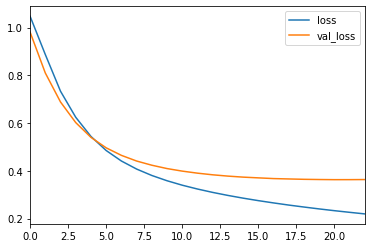

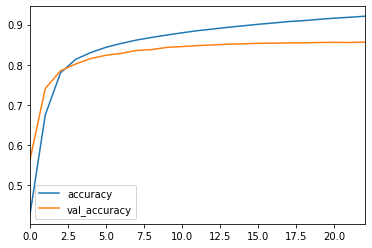

In [87]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 1

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

In [91]:
def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),
        GRU(units),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 9s 121us/sample - loss: 0.7708 - accuracy: 0.6025 - val_loss: 0.5432 - val_accuracy: 0.7528
Epoch 2/100
76962/76962 [==============================] - 6s 79us/sample - loss: 0.3846 - accuracy: 0.8445 - val_loss: 0.3820 - val_accuracy: 0.8478
Epoch 3/100
76962/76962 [==============================] - 6s 81us/sample - loss: 0.2589 - accuracy: 0.9028 - val_loss: 0.3823 - val_accuracy: 0.8522
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 26, 10)            472720    
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 51        
Total params: 

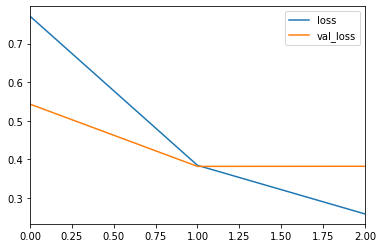

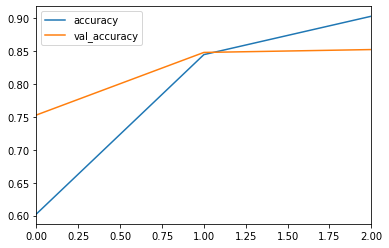

In [98]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 0

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

## Build a CNN model

In [40]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),
        Conv1D(
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),
        Flatten(),
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Train on 76962 samples, validate on 19241 samples
Epoch 1/100
76962/76962 [==============================] - 2s 32us/sample - loss: 0.6710 - accuracy: 0.6843 - val_loss: 0.4211 - val_accuracy: 0.8303
Epoch 2/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.3292 - accuracy: 0.8680 - val_loss: 0.3726 - val_accuracy: 0.8528
Epoch 3/100
76962/76962 [==============================] - 2s 27us/sample - loss: 0.2410 - accuracy: 0.9072 - val_loss: 0.3856 - val_accuracy: 0.8507
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 26, 5)             236360    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 12, 200)           3200      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2400)              0         
_______________

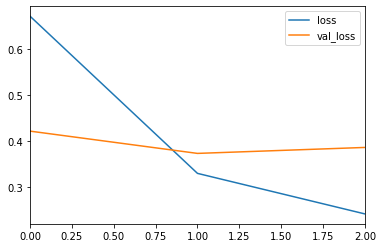

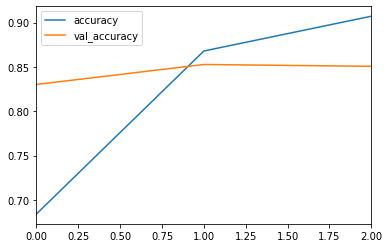

In [97]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

### Comparing the models

In [99]:
!tensorboard --logdir $LOGDIR

TensorBoard 2.0.0a20190917 at http://dherin-macbookpro.roam.corp.google.com:6006/ (Press CTRL+C to quit)
^C


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License